In [1]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from skimage.metrics import structural_similarity as ssim

In [2]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [3]:
data_path = "../data/chest_xray"

In [4]:
dataset = torchvision.datasets.ImageFolder(root=data_path, 
                                 transform = None,
                                 target_transform = None,
                                 )

In [5]:
len(dataset)

5856

In [6]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [7]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

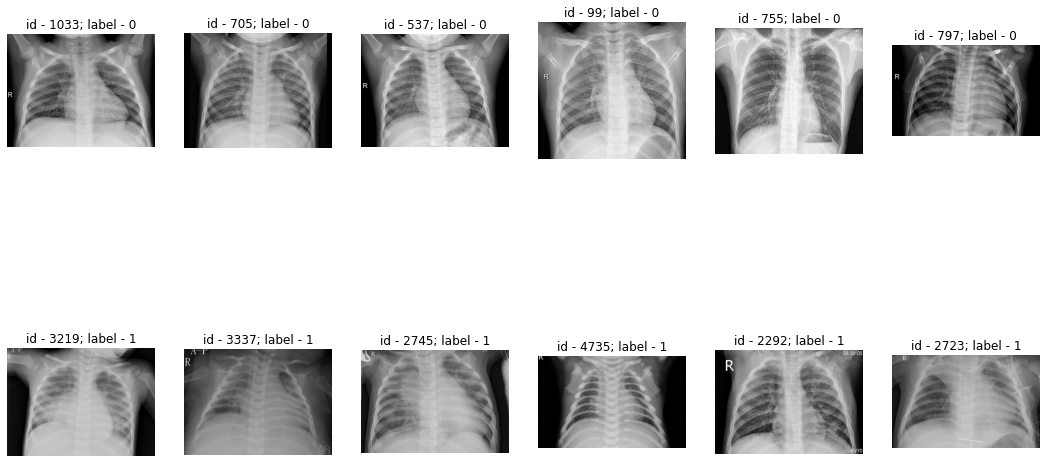

In [8]:
visualize_classes(dataset)

In [9]:
dataset = torchvision.datasets.ImageFolder(
    root=data_path, 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [10]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

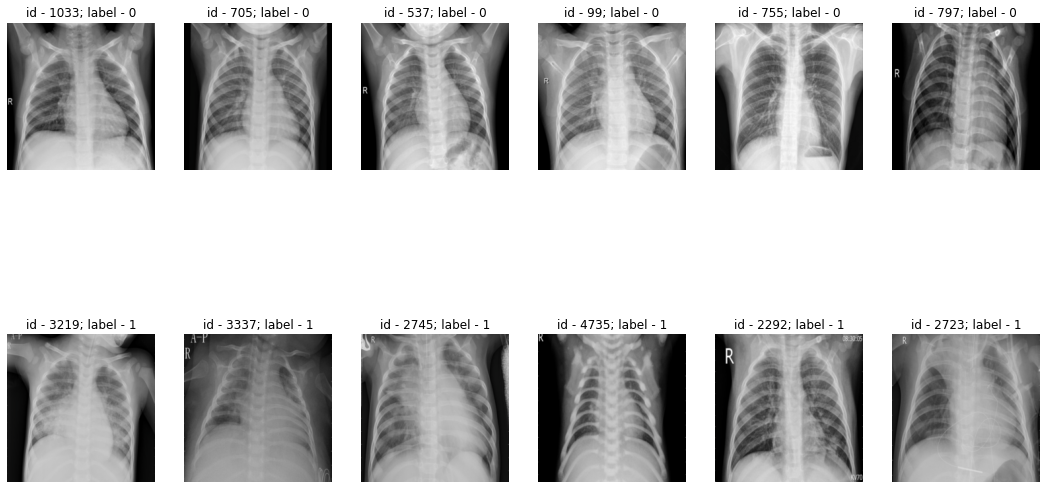

In [11]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [12]:
device = "cuda:0"
# device = "cpu"

In [13]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=0
)

### Load model

In [15]:
save_path = "../models/5.3_vgg11_bn_2021-04-13_02:58:10.pt"

In [17]:
model = models.vgg11_bn()
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Analyze results

In [18]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 37/37 [00:50<00:00,  1.36s/it]


In [19]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [20]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [21]:
df["error_type"] = df.apply(error_class, axis=1)

In [22]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,84,84,84
FP,47,47,47
TN,260,260,260
TP,781,781,781


In [23]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.8882252559726962
average_precision_score - 0.9233115161004068


In [24]:
n = 10
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [25]:
df

,true,pred,prob,error_type
0,1,1,1.000000e+00,TP
1,1,1,1.000000e+00,TP
2,1,0,4.496583e-13,FN
3,0,0,3.868548e-21,TN
4,0,0,1.201345e-37,TN
...,...,...,...,...
1167,1,1,1.000000e+00,TP
1168,1,1,1.000000e+00,TP
1169,1,1,1.000000e+00,TP
1170,1,1,1.000000e+00,TP


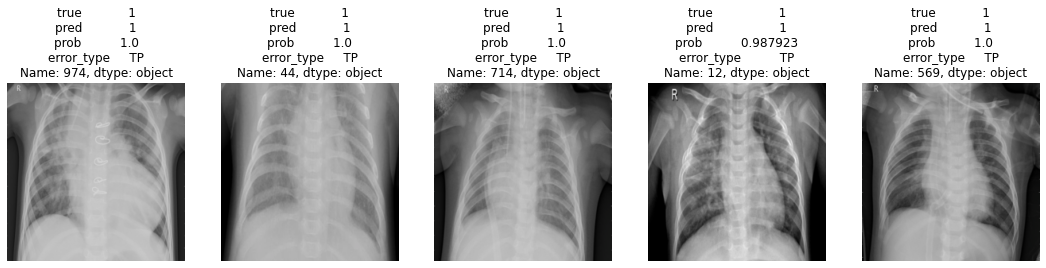

In [26]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

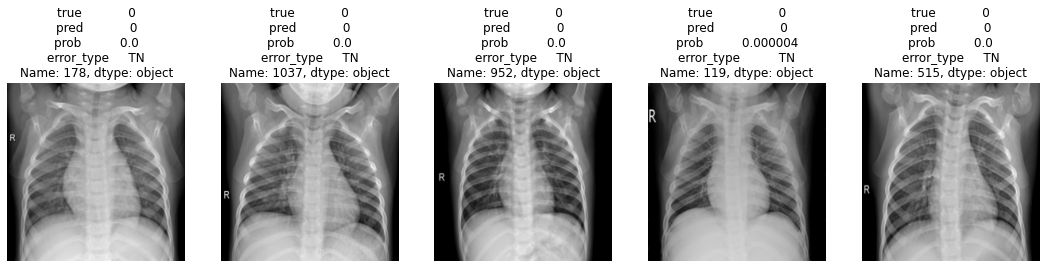

In [27]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

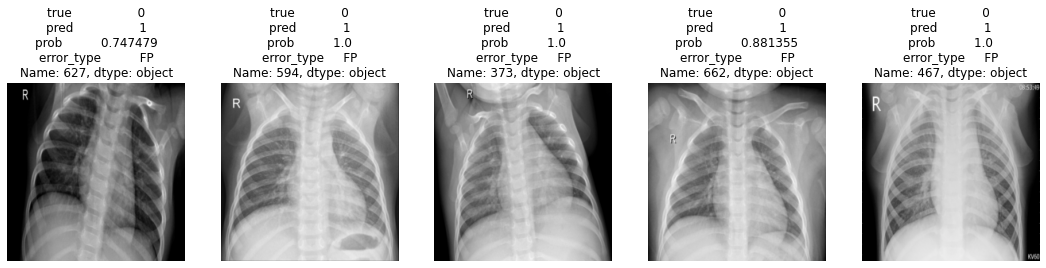

In [28]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

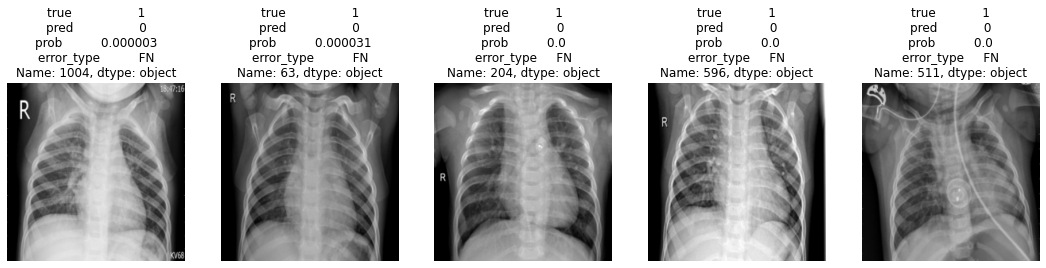

In [29]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [30]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [31]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

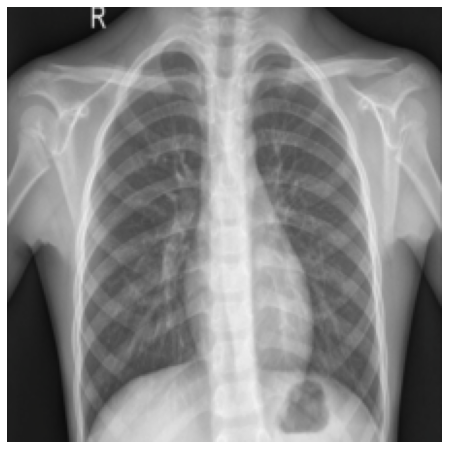

1.5249381e-10

In [32]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [33]:
from art.estimators.classification import PyTorchClassifier

In [34]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [35]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

1.5249381e-10


#### Loss gradient 

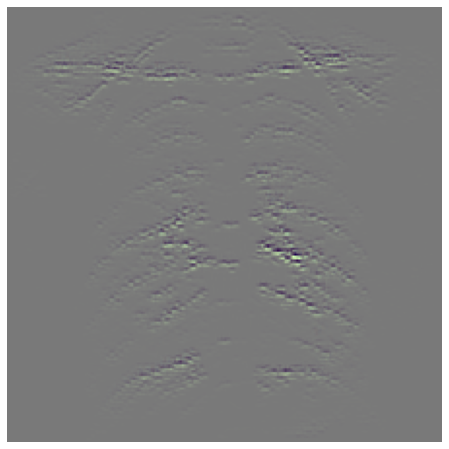

In [36]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [37]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

### Metrics

#### Original data

In [38]:
def get_misclassification_rate(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FP"] + errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [39]:
def get_robustness_to_gaussian_blur(df_blur, df_orig):
    robustness_to_gaussian_blur = len(df_blur[df_blur["pred"]!=df_blur["true"]]) / len(df_orig[df_orig["pred"]!=df_orig["true"]])
    return robustness_to_gaussian_blur

In [40]:
def get_av_ssim(orig_images, adv_images):
    values = []
    for i in tqdm(range(len(orig_images))):
        values.append(ssim(np.transpose(orig_images[i], (1, 2, 0)), np.transpose(adv_images[i], (1, 2, 0)), multichannel=True))
    return np.mean(values)

In [41]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [42]:
def get_preds(adv = None, batch_size=1, max_iter=None):
    prob = []
    pred = []
    true = []
#     images = []
#     original_images = []
    
    if max_iter is not None:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        )
    else:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        )
    counter = 0
    for image, label in tqdm(loader, total=max_iter if max_iter is not None else len(loader)):
#         if max_iter is not None:
#             original_images.append(np.array(image[0]).copy())
        if adv is not None:
            image = adv.generate(image.cpu(), y=to_categorical([1-label], nb_classes=2))
        pred_adv = art_classifier.predict(image)[:,1].reshape(-1)
        prob.extend(list(pred_adv))
        pred.extend(list((pred_adv > 0.5).astype(int)))
        true.extend(list(label.numpy().reshape(-1)))
#         images.append(np.array(image[0]))
        if max_iter is not None:
            counter += 1
            if counter >= max_iter:
                break

    df = pd.DataFrame({"prob":prob, "pred":pred, "true":true})
    df["error_type"] = df.apply(error_class, axis=1)
    return df
    if max_iter is not None:
        return df, np.array(images), np.array(original_images)
    else:
        return df, np.array(images)

In [43]:
df_orig = get_preds()

100%|██████████| 1172/1172 [00:23<00:00, 50.68it/s]


In [44]:
misclassification_rate = get_misclassification_rate(df_orig)
misclassification_rate

11.177474402730375

In [45]:
# df_orig_blur, orig_blur_images = get_preds(blur=True)

In [46]:
# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_orig_blur, df_orig)
# robustness_to_gaussian_blur

In [47]:
# misclassification_rate = get_misclassification_rate(df_orig_blur)
# misclassification_rate

In [48]:
# average_ssim = get_av_ssim(orig_images, orig_blur_images)
# average_ssim

#### ProjectedGradientDescent

In [49]:
adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=50, eps_step=1, eps=0.02)

In [50]:
df_pgd = get_preds(adv, batch_size=1, max_iter=111)

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:01<02:43,  1.48s/it]

  2%|▏         | 2/111 [00:02<02:37,  1.44s/it]

  3%|▎         | 3/111 [00:04<02:32,  1.41s/it]

  4%|▎         | 4/111 [00:05<02:26,  1.37s/it]

  5%|▍         | 5/111 [00:06<02:24,  1.36s/it]

  5%|▌         | 6/111 [00:08<02:22,  1.36s/it]

  6%|▋         | 7/111 [00:09<02:20,  1.35s/it]

  7%|▋         | 8/111 [00:10<02:18,  1.34s/it]

  8%|▊         | 9/111 [00:12<02:17,  1.35s/it]

  9%|▉         | 10/111 [00:13<02:13,  1.32s/it]

 10%|▉         | 11/111 [00:14<02:12,  1.33s/it]

 11%|█         | 12/111 [00:16<02:11,  1.33s/it]

 12%|█▏        | 13/111 [00:17<02:08,  1.31s/it]

 13%|█▎        | 14/111 [00:18<02:07,  1.31s/it]

 14%|█▎        | 15/111 [00:19<02:06,  1.32s/it]

 14%|█▍        | 16/111 [00:21<02:04,  1.31s/it]

 15%|█▌        | 17/111 [00:22<02:03,  1.31s/it]

 16%|█▌        | 18/111 [00:23<02:01,  1.31s/it]

 17%|█▋        | 19/111 [00:24<01:52,  1.22s/it]

 18%|█▊        | 20/111 [00:26<01:53,  1.25s/it]

 19%|█▉        | 21/111 [00:27<01:54,  1.28s/it]

 20%|█▉        | 22/111 [00:28<01:53,  1.27s/it]

 21%|██        | 23/111 [00:30<01:54,  1.30s/it]

 22%|██▏       | 24/111 [00:31<01:53,  1.30s/it]

 23%|██▎       | 25/111 [00:32<01:51,  1.29s/it]

 23%|██▎       | 26/111 [00:34<01:50,  1.30s/it]

 24%|██▍       | 27/111 [00:35<01:49,  1.30s/it]

 25%|██▌       | 28/111 [00:36<01:48,  1.31s/it]

 26%|██▌       | 29/111 [00:38<01:49,  1.33s/it]

 27%|██▋       | 30/111 [00:39<01:46,  1.32s/it]

 28%|██▊       | 31/111 [00:40<01:45,  1.32s/it]

 29%|██▉       | 32/111 [00:42<01:44,  1.32s/it]

 30%|██▉       | 33/111 [00:43<01:41,  1.31s/it]

 31%|███       | 34/111 [00:44<01:41,  1.32s/it]

 32%|███▏      | 35/111 [00:45<01:39,  1.31s/it]

 32%|███▏      | 36/111 [00:47<01:37,  1.29s/it]

 33%|███▎      | 37/111 [00:48<01:36,  1.30s/it]

 34%|███▍      | 38/111 [00:49<01:36,  1.32s/it]

 35%|███▌      | 39/111 [00:51<01:34,  1.31s/it]

 36%|███▌      | 40/111 [00:52<01:33,  1.31s/it]

 37%|███▋      | 41/111 [00:53<01:32,  1.32s/it]

 38%|███▊      | 42/111 [00:55<01:30,  1.31s/it]

 39%|███▊      | 43/111 [00:56<01:29,  1.31s/it]

 40%|███▉      | 44/111 [00:57<01:28,  1.33s/it]

 41%|████      | 45/111 [00:59<01:27,  1.32s/it]

 41%|████▏     | 46/111 [01:00<01:26,  1.33s/it]

 42%|████▏     | 47/111 [01:01<01:23,  1.31s/it]

 43%|████▎     | 48/111 [01:03<01:22,  1.31s/it]

 44%|████▍     | 49/111 [01:04<01:21,  1.32s/it]

 45%|████▌     | 50/111 [01:05<01:19,  1.31s/it]

 46%|████▌     | 51/111 [01:07<01:19,  1.32s/it]

 47%|████▋     | 52/111 [01:08<01:18,  1.33s/it]

 48%|████▊     | 53/111 [01:09<01:16,  1.31s/it]

 49%|████▊     | 54/111 [01:10<01:15,  1.32s/it]

 50%|████▉     | 55/111 [01:12<01:14,  1.33s/it]

 50%|█████     | 56/111 [01:13<01:12,  1.32s/it]

 51%|█████▏    | 57/111 [01:14<01:11,  1.33s/it]

 52%|█████▏    | 58/111 [01:16<01:09,  1.32s/it]

 53%|█████▎    | 59/111 [01:17<01:07,  1.30s/it]

 54%|█████▍    | 60/111 [01:18<01:06,  1.31s/it]

 55%|█████▍    | 61/111 [01:20<01:05,  1.31s/it]

 56%|█████▌    | 62/111 [01:21<01:03,  1.30s/it]

 57%|█████▋    | 63/111 [01:22<01:06,  1.38s/it]

 58%|█████▊    | 64/111 [01:24<01:01,  1.30s/it]

 59%|█████▊    | 65/111 [01:25<00:57,  1.24s/it]

 59%|█████▉    | 66/111 [01:26<00:57,  1.28s/it]

 60%|██████    | 67/111 [01:27<00:56,  1.29s/it]

 61%|██████▏   | 68/111 [01:29<00:56,  1.31s/it]

 62%|██████▏   | 69/111 [01:30<00:55,  1.32s/it]

 63%|██████▎   | 70/111 [01:31<00:53,  1.31s/it]

 64%|██████▍   | 71/111 [01:33<00:52,  1.30s/it]

 65%|██████▍   | 72/111 [01:34<00:51,  1.31s/it]

 66%|██████▌   | 73/111 [01:35<00:49,  1.31s/it]

 67%|██████▋   | 74/111 [01:37<00:48,  1.32s/it]

 68%|██████▊   | 75/111 [01:38<00:47,  1.31s/it]

 68%|██████▊   | 76/111 [01:39<00:45,  1.30s/it]

 69%|██████▉   | 77/111 [01:41<00:44,  1.30s/it]

 70%|███████   | 78/111 [01:42<00:43,  1.31s/it]

 71%|███████   | 79/111 [01:43<00:42,  1.32s/it]

 72%|███████▏  | 80/111 [01:45<00:40,  1.32s/it]

 73%|███████▎  | 81/111 [01:46<00:39,  1.32s/it]

 74%|███████▍  | 82/111 [01:47<00:38,  1.31s/it]

 75%|███████▍  | 83/111 [01:48<00:36,  1.32s/it]

 76%|███████▌  | 84/111 [01:50<00:35,  1.32s/it]

 77%|███████▋  | 85/111 [01:51<00:34,  1.33s/it]

 77%|███████▋  | 86/111 [01:52<00:33,  1.32s/it]

 78%|███████▊  | 87/111 [01:54<00:31,  1.32s/it]

 79%|███████▉  | 88/111 [01:55<00:30,  1.32s/it]

 80%|████████  | 89/111 [01:56<00:29,  1.32s/it]

 81%|████████  | 90/111 [01:58<00:27,  1.33s/it]

 82%|████████▏ | 91/111 [01:59<00:26,  1.33s/it]

 83%|████████▎ | 92/111 [02:00<00:25,  1.34s/it]

 84%|████████▍ | 93/111 [02:02<00:23,  1.32s/it]

 85%|████████▍ | 94/111 [02:03<00:22,  1.32s/it]

 86%|████████▌ | 95/111 [02:04<00:21,  1.33s/it]

 86%|████████▋ | 96/111 [02:06<00:19,  1.32s/it]

 87%|████████▋ | 97/111 [02:07<00:18,  1.32s/it]

 88%|████████▊ | 98/111 [02:08<00:16,  1.31s/it]

 89%|████████▉ | 99/111 [02:10<00:15,  1.31s/it]

 90%|█████████ | 100/111 [02:11<00:14,  1.32s/it]

 91%|█████████ | 101/111 [02:12<00:13,  1.32s/it]

 92%|█████████▏| 102/111 [02:14<00:11,  1.33s/it]

 93%|█████████▎| 103/111 [02:15<00:10,  1.32s/it]

 94%|█████████▎| 104/111 [02:16<00:09,  1.31s/it]

 95%|█████████▍| 105/111 [02:18<00:07,  1.31s/it]

 95%|█████████▌| 106/111 [02:19<00:06,  1.31s/it]

 96%|█████████▋| 107/111 [02:20<00:05,  1.32s/it]

 97%|█████████▋| 108/111 [02:21<00:03,  1.32s/it]

 98%|█████████▊| 109/111 [02:23<00:02,  1.33s/it]

 99%|█████████▉| 110/111 [02:24<00:01,  1.30s/it]

 99%|█████████▉| 110/111 [02:25<00:01,  1.33s/it]


In [51]:
# df_pgd_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [52]:
misclassification_rate = get_misclassification_rate(df_pgd)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_pgd_blur, df_pgd)

# average_ssim = get_av_ssim(orig_images, pgd_images)

In [53]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

18.01801801801802

#### BasicIterativeMethod

In [54]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

In [55]:
adv = BasicIterativeMethod(art_classifier, eps = 0.1, eps_step = 0.1, max_iter = 100, targeted = True)

In [56]:
df_bim = get_preds(adv, batch_size=1, max_iter=111)

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:02<04:58,  2.71s/it]

  2%|▏         | 2/111 [00:05<04:51,  2.67s/it]

  3%|▎         | 3/111 [00:07<04:45,  2.64s/it]

  4%|▎         | 4/111 [00:10<04:42,  2.64s/it]

  5%|▍         | 5/111 [00:13<04:36,  2.61s/it]

  5%|▌         | 6/111 [00:15<04:34,  2.61s/it]

  6%|▋         | 7/111 [00:18<04:31,  2.61s/it]

  7%|▋         | 8/111 [00:20<04:27,  2.60s/it]

  8%|▊         | 9/111 [00:23<04:24,  2.59s/it]

  9%|▉         | 10/111 [00:26<04:22,  2.60s/it]

 10%|▉         | 11/111 [00:28<04:18,  2.58s/it]

 11%|█         | 12/111 [00:31<04:15,  2.58s/it]

 12%|█▏        | 13/111 [00:33<04:14,  2.59s/it]

 13%|█▎        | 14/111 [00:36<04:09,  2.57s/it]

 14%|█▎        | 15/111 [00:38<04:07,  2.57s/it]

 14%|█▍        | 16/111 [00:41<04:03,  2.57s/it]

 15%|█▌        | 17/111 [00:43<04:01,  2.57s/it]

 16%|█▌        | 18/111 [00:46<04:00,  2.59s/it]

 17%|█▋        | 19/111 [00:49<03:58,  2.59s/it]

 18%|█▊        | 20/111 [00:51<03:54,  2.58s/it]

 19%|█▉        | 21/111 [00:54<03:52,  2.58s/it]

 20%|█▉        | 22/111 [00:56<03:49,  2.58s/it]

 21%|██        | 23/111 [00:59<03:47,  2.59s/it]

 22%|██▏       | 24/111 [01:02<03:45,  2.59s/it]

 23%|██▎       | 25/111 [01:04<03:41,  2.57s/it]

 23%|██▎       | 26/111 [01:07<03:39,  2.58s/it]

 24%|██▍       | 27/111 [01:09<03:37,  2.60s/it]

 25%|██▌       | 28/111 [01:12<03:33,  2.57s/it]

 26%|██▌       | 29/111 [01:15<03:31,  2.58s/it]

 27%|██▋       | 30/111 [01:17<03:29,  2.59s/it]

 28%|██▊       | 31/111 [01:20<03:26,  2.58s/it]

 29%|██▉       | 32/111 [01:22<03:24,  2.58s/it]

 30%|██▉       | 33/111 [01:25<03:21,  2.59s/it]

 31%|███       | 34/111 [01:27<03:17,  2.57s/it]

 32%|███▏      | 35/111 [01:30<03:14,  2.56s/it]

 32%|███▏      | 36/111 [01:33<03:13,  2.57s/it]

 33%|███▎      | 37/111 [01:35<03:09,  2.56s/it]

 34%|███▍      | 38/111 [01:38<03:07,  2.58s/it]

 35%|███▌      | 39/111 [01:40<03:06,  2.60s/it]

 36%|███▌      | 40/111 [01:43<03:04,  2.60s/it]

 37%|███▋      | 41/111 [01:46<03:01,  2.59s/it]

 38%|███▊      | 42/111 [01:48<02:58,  2.58s/it]

 39%|███▊      | 43/111 [01:51<02:55,  2.59s/it]

 40%|███▉      | 44/111 [01:53<02:54,  2.61s/it]

 41%|████      | 45/111 [01:56<02:51,  2.60s/it]

 41%|████▏     | 46/111 [01:58<02:47,  2.58s/it]

 42%|████▏     | 47/111 [02:01<02:45,  2.59s/it]

 43%|████▎     | 48/111 [02:04<02:43,  2.59s/it]

 44%|████▍     | 49/111 [02:06<02:42,  2.62s/it]

 45%|████▌     | 50/111 [02:09<02:39,  2.62s/it]

 46%|████▌     | 51/111 [02:12<02:36,  2.61s/it]

 47%|████▋     | 52/111 [02:14<02:34,  2.61s/it]

 48%|████▊     | 53/111 [02:17<02:31,  2.62s/it]

 49%|████▊     | 54/111 [02:19<02:28,  2.60s/it]

 50%|████▉     | 55/111 [02:22<02:25,  2.60s/it]

 50%|█████     | 56/111 [02:25<02:22,  2.60s/it]

 51%|█████▏    | 57/111 [02:27<02:19,  2.59s/it]

 52%|█████▏    | 58/111 [02:30<02:17,  2.59s/it]

 53%|█████▎    | 59/111 [02:32<02:15,  2.60s/it]

 54%|█████▍    | 60/111 [02:35<02:12,  2.59s/it]

 55%|█████▍    | 61/111 [02:38<02:10,  2.60s/it]

 56%|█████▌    | 62/111 [02:40<02:06,  2.59s/it]

 57%|█████▋    | 63/111 [02:43<02:03,  2.58s/it]

 58%|█████▊    | 64/111 [02:45<02:00,  2.57s/it]

 59%|█████▊    | 65/111 [02:48<01:58,  2.59s/it]

 59%|█████▉    | 66/111 [02:50<01:55,  2.57s/it]

 60%|██████    | 67/111 [02:53<01:53,  2.58s/it]

 61%|██████▏   | 68/111 [02:56<01:51,  2.58s/it]

 62%|██████▏   | 69/111 [02:58<01:47,  2.56s/it]

 63%|██████▎   | 70/111 [03:01<01:45,  2.57s/it]

 64%|██████▍   | 71/111 [03:03<01:42,  2.57s/it]

 65%|██████▍   | 72/111 [03:06<01:40,  2.57s/it]

 66%|██████▌   | 73/111 [03:08<01:37,  2.57s/it]

 67%|██████▋   | 74/111 [03:11<01:35,  2.58s/it]

 68%|██████▊   | 75/111 [03:14<01:33,  2.58s/it]

 68%|██████▊   | 76/111 [03:16<01:31,  2.61s/it]

 69%|██████▉   | 77/111 [03:19<01:28,  2.60s/it]

 70%|███████   | 78/111 [03:21<01:25,  2.60s/it]

 71%|███████   | 79/111 [03:24<01:23,  2.62s/it]

 72%|███████▏  | 80/111 [03:27<01:21,  2.62s/it]

 73%|███████▎  | 81/111 [03:29<01:18,  2.62s/it]

 74%|███████▍  | 82/111 [03:32<01:16,  2.63s/it]

 75%|███████▍  | 83/111 [03:35<01:13,  2.61s/it]

 76%|███████▌  | 84/111 [03:37<01:10,  2.62s/it]

 77%|███████▋  | 85/111 [03:40<01:08,  2.63s/it]

 77%|███████▋  | 86/111 [03:42<01:05,  2.61s/it]

 78%|███████▊  | 87/111 [03:45<01:02,  2.61s/it]

 79%|███████▉  | 88/111 [03:48<01:00,  2.62s/it]

 80%|████████  | 89/111 [03:50<00:57,  2.59s/it]

 81%|████████  | 90/111 [03:53<00:54,  2.60s/it]

 82%|████████▏ | 91/111 [03:55<00:52,  2.61s/it]

 83%|████████▎ | 92/111 [03:58<00:49,  2.61s/it]

 84%|████████▍ | 93/111 [04:01<00:46,  2.61s/it]

 85%|████████▍ | 94/111 [04:03<00:43,  2.59s/it]

 86%|████████▌ | 95/111 [04:06<00:41,  2.60s/it]

 86%|████████▋ | 96/111 [04:08<00:39,  2.61s/it]

 87%|████████▋ | 97/111 [04:11<00:36,  2.60s/it]

 88%|████████▊ | 98/111 [04:14<00:33,  2.61s/it]

 89%|████████▉ | 99/111 [04:16<00:31,  2.61s/it]

 90%|█████████ | 100/111 [04:19<00:28,  2.60s/it]

 91%|█████████ | 101/111 [04:21<00:26,  2.60s/it]

 92%|█████████▏| 102/111 [04:24<00:23,  2.61s/it]

 93%|█████████▎| 103/111 [04:27<00:20,  2.58s/it]

 94%|█████████▎| 104/111 [04:29<00:18,  2.58s/it]

 95%|█████████▍| 105/111 [04:32<00:15,  2.60s/it]

 95%|█████████▌| 106/111 [04:34<00:12,  2.59s/it]

 96%|█████████▋| 107/111 [04:37<00:10,  2.60s/it]

 97%|█████████▋| 108/111 [04:40<00:07,  2.61s/it]

 98%|█████████▊| 109/111 [04:42<00:05,  2.59s/it]

 99%|█████████▉| 110/111 [04:45<00:02,  2.61s/it]

 99%|█████████▉| 110/111 [04:47<00:02,  2.62s/it]


In [57]:
# df_bim_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [58]:
misclassification_rate = get_misclassification_rate(df_bim)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_bim_blur, df_bim)

# average_ssim = get_av_ssim(orig_images, bim_images)

In [59]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

36.93693693693694

#### ElasticNet

In [60]:
adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= 100, 
                     beta = 0.01,)

In [61]:
df_en  = get_preds(adv, batch_size=1, max_iter=31)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [01:04<32:13, 64.46s/it]

  6%|▋         | 2/31 [02:08<31:05, 64.33s/it]

 10%|▉         | 3/31 [03:12<29:56, 64.15s/it]

 13%|█▎        | 4/31 [04:16<28:52, 64.18s/it]

 16%|█▌        | 5/31 [05:20<27:46, 64.09s/it]

 19%|█▉        | 6/31 [06:24<26:43, 64.16s/it]

 23%|██▎       | 7/31 [07:28<25:35, 63.97s/it]

 26%|██▌       | 8/31 [08:27<23:59, 62.59s/it]

 29%|██▉       | 9/31 [09:26<22:34, 61.56s/it]

 32%|███▏      | 10/31 [10:25<21:14, 60.70s/it]

 35%|███▌      | 11/31 [11:24<20:04, 60.21s/it]

 39%|███▊      | 12/31 [12:23<18:57, 59.87s/it]

 42%|████▏     | 13/31 [13:22<17:53, 59.66s/it]

 45%|████▌     | 14/31 [14:23<16:57, 59.87s/it]

 48%|████▊     | 15/31 [15:22<15:54, 59.69s/it]

 52%|█████▏    | 16/31 [16:21<14:52, 59.50s/it]

 55%|█████▍    | 17/31 [17:19<13:47, 59.12s/it]

 58%|█████▊    | 18/31 [18:18<12:47, 59.01s/it]

 61%|██████▏   | 19/31 [19:11<11:27, 57.29s/it]

 65%|██████▍   | 20/31 [20:10<10:35, 57.74s/it]

 68%|██████▊   | 21/31 [21:10<09:43, 58.30s/it]

 71%|███████   | 22/31 [22:09<08:46, 58.52s/it]

 74%|███████▍  | 23/31 [23:07<07:47, 58.48s/it]

 77%|███████▋  | 24/31 [24:06<06:49, 58.50s/it]

 81%|████████  | 25/31 [25:05<05:52, 58.78s/it]

 84%|████████▍ | 26/31 [26:04<04:54, 58.89s/it]

 87%|████████▋ | 27/31 [27:04<03:56, 59.07s/it]

 90%|█████████ | 28/31 [28:03<02:57, 59.05s/it]

 94%|█████████▎| 29/31 [29:02<01:58, 59.05s/it]

 97%|█████████▋| 30/31 [30:00<00:58, 58.94s/it]

 97%|█████████▋| 30/31 [31:00<01:02, 62.00s/it]

In [62]:
# df_en_blur, _, _ = get_preds(adv, batch_size=1, blur=True, max_iter=100)

In [65]:
def get_misclassification_rate_en(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [66]:
misclassification_rate = get_misclassification_rate_en(df_en)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_en_blur, df_en)

# average_ssim = get_av_ssim(en_images_original, en_images)

In [67]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

9.67741935483871

#### Fast Gradient Method 

In [68]:
adv = FastGradientMethod(
        art_classifier,
        norm = 2, 
        eps = 10, 
        eps_step = 0.1, 
        targeted = True
    )

In [69]:
df_fgm = get_preds(adv, batch_size=1, max_iter=111)

 99%|█████████▉| 110/111 [00:03<00:00, 29.97it/s]


In [70]:
# df_fgm_blur, _ = get_preds(adv, batch_size=1, blur=True)

In [71]:
misclassification_rate = get_misclassification_rate(df_fgm)

# robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_fgm_blur, df_fgm)

# average_ssim = get_av_ssim(orig_images, fgm_images)

In [72]:
misclassification_rate
# , robustness_to_gaussian_blur, average_ssim

13.513513513513514